# Associations between microbial presence/absence and patient info

In [1]:
setwd("/mnt/c/git_repos/blood_microbial_signatures/")
require(tidyverse)
require(ggplot2)
require(data.table)
require(foreach)
require(doParallel)
require(ggrepel)
registerDoParallel(cores = 8)


Loading required package: tidyverse

Warning message:
“package ‘tidyverse’ was built under R version 4.1.3”
Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 1.0.0
Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”
Warning message:
“package ‘tibble’ was built under R version 4.1.3”
Warning message:
“package ‘tidyr’ was built under R version 4.1.3”
Warning message:
“package ‘readr’ was built under R version 4.1.3”
Warning message:
“package ‘purrr’ was built under R version 4.1.3”
Warning message:
“package ‘dplyr’ was built under R version 4.1.3”
Warning message:
“package ‘stringr’ was built under R version 4.1.3”
Warning messa

### Load  data

In [2]:
X <- fread("results/decontamination/prevalence_RA0.005_read10.csv")
nc <- fread("results/decontamination/curated_n117_global_decontamination_stats.parsed.csv")
X <- X %>% select(all_of(c("npm_research_id", nc$taxa)))

meta <- fread("data/20210125_v3_release/20210203_all_traits_v3.txt")
meta2 <- fread("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv")

n <- gsub("[^0-9A-Za-z///' ]", " ", colnames(meta))
n <- tolower(n)
n <- gsub(" ", "_", n)
colnames(meta) <- n

# fwrite(meta, "data/20210125_v3_release/20210203_all_traits_v3.parsed.csv")

In [3]:
meta2 %>% 
group_by(site_supplying_sample) %>%
summarise(n = n())

site_supplying_sample,n
<chr>,<int>
GUSTO,969
HELIOS,2286
MEC,2902
PRISM,1257
SEED,1436
TTSH,920


In [4]:
meta_cols <- c('site_supplying_sample',
               'extraction_kit',
               'hiseq_xtm_sbs_kit_300_cycles_v2__box_1of_2__lot',
               'hiseq_xtm_sbs_kit_300_cycles_v2__box_2_of_2__lot',
               'hiseq_xtm_pe_cluster_kit_cbottm_v2__box_1_of_2__lot',
               'hiseq_xtm_pe_cluster_kit_cbottm_v2__box_2_of_2__lot',
               'hiseq_xtm_flow_cell_v2_5_lot')
X %>% 
    left_join(meta2 %>% select(all_of(c(meta_cols, "npm_research_id", "site_supplying_sample")))) %>% 
    filter(site_supplying_sample == "GUSTO") %>%
    distinct(extraction_kit)
#     select(-site_supplying_sample) %>%
#     pivot_longer(!npm_research_id, names_to = "taxa", values_to = "presence")

Joining with `by = join_by(npm_research_id)`


extraction_kit
<chr>
QIAsymphony DSP DNA Midi Kit


### Prevalence of taxa stratified by cohort

In [5]:
commensals <- nc %>% 
    filter(!(site %in% c("", "eye"))) %>%
    mutate(site = ifelse(site == "respiratory tract", "resp. tract", site)) %>%
    select(taxa, site)

site_morsels <- foreach(taxon = unique(commensals$taxa)) %do% {
    temp <- commensals %>%
        filter(taxa == taxon)
    if (nrow(temp) > 1) {
        temp %>% 
            distinct(taxa, .keep_all = T) %>%
            mutate(site = "Multiple")
    } else {
        temp
    }
}

commensals <- bind_rows(site_morsels)

In [6]:
pal <- list(Oral = "royalblue", Blood = "indianred",
            "Resp. tract" = "cadetblue", "Genitourinary tract" = "pink2",
            Skin = "wheat", Gut = "thistle", Multiple = "grey")

`summarise()` has grouped output by 'site_supplying_sample'. You can override using the `.groups` argument.
Joining with `by = join_by(taxa)`


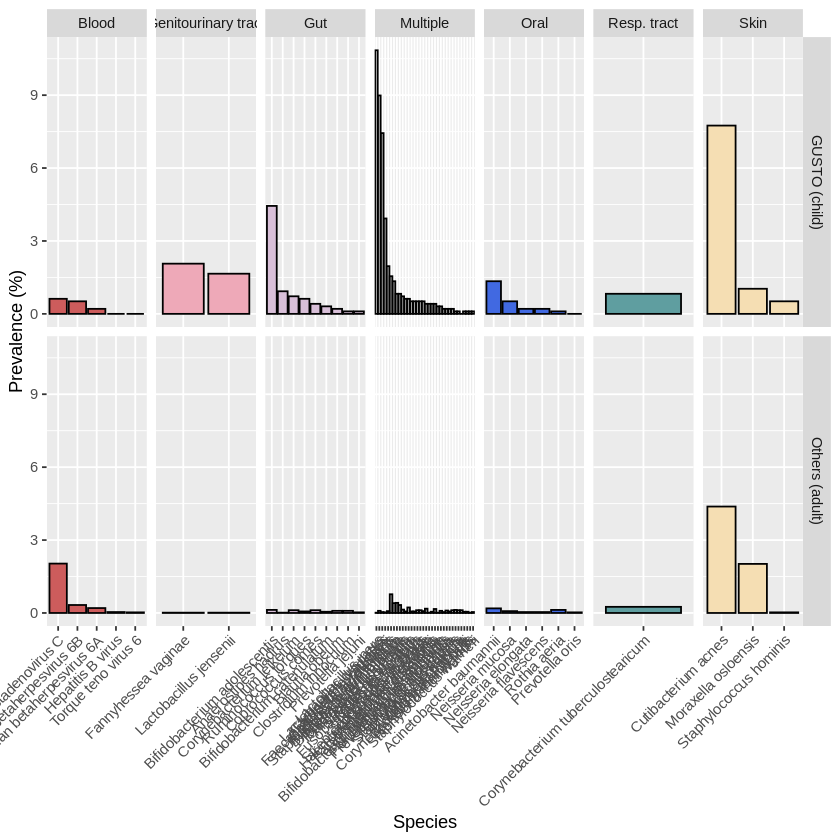

In [7]:
commensals <- nc %>% 
    filter(!(site %in% c("", "eye"))) %>%
    mutate(site = ifelse(site == "respiratory tract", "resp. tract", site)) %>%
    select(taxa, site)

site_morsels <- foreach(taxon = unique(commensals$taxa)) %do% {
    temp <- commensals %>%
        filter(taxa == taxon)
    if (nrow(temp) > 1) {
        temp %>% 
            distinct(taxa, .keep_all = T) %>%
            mutate(site = "Multiple")
    } else {
        temp
    }
}

commensals <- bind_rows(site_morsels)

finer_plot_df <- X %>%
    left_join(meta2 %>% select(npm_research_id, site_supplying_sample), "npm_research_id") %>%
    mutate(site_supplying_sample = ifelse(site_supplying_sample == "GUSTO", "GUSTO (child)", "Others (adult)")) %>%
    pivot_longer(!c(npm_research_id, site_supplying_sample), 
                 names_to = "taxa", values_to = "presence") %>%
    group_by(site_supplying_sample, taxa) %>%
    summarise(prev = sum(presence) / n(), n = n()) %>%
    left_join(commensals) %>%
    filter(!is.na(site)) %>%
    mutate(site = Hmisc::capitalize(site)) %>%
    mutate(site = ifelse(site == "Respiratory tract", "Resp. tract", site)) %>%
    arrange(desc(prev), site)

finer_plot_df %>%
    mutate(taxa = factor(taxa, unique(finer_plot_df$taxa))) %>%
    ggplot(aes(x = taxa, y = prev * 100, fill = site)) +
    geom_bar(stat = "identity", color = "black") +
    facet_grid(rows = vars(site_supplying_sample),
               cols = vars(site),
               scales = "free_x") +
    scale_fill_manual(values = pal) +
    theme(legend.position = "none",
          axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(x = "Species", y = "Prevalence (%)")

ggsave("results/GUSTO_versus_rest/prevalence_by_taxa_site_cohort.png", dpi = 600, width = 30, height = 8)

#### Prevalence by site and cohort

In [8]:
site_list <- unique(commensals$site)
site_morsels2 <- foreach(site_name = site_list) %do% {
    taxa_list <- (commensals %>% filter(site == site_name))$taxa
    X_site_temp <- X %>%
        column_to_rownames("npm_research_id") %>%
        select(all_of(taxa_list)) %>%
        mutate(combined = rowSums(.), .before = 1)  %>%
        mutate(combined = ifelse(combined > 0, 1, 0)) %>%
        select(combined)

    colnames(X_site_temp) <- site_name
    X_site_temp
}

X_meta <- bind_cols(site_morsels2) %>%
    rownames_to_column("npm_research_id") %>%
    left_join(meta, "npm_research_id") %>%
    left_join(meta2, "npm_research_id") %>%
    as_tibble()

`summarise()` has grouped output by 'site_supplying_sample'. You can override using the `.groups` argument.


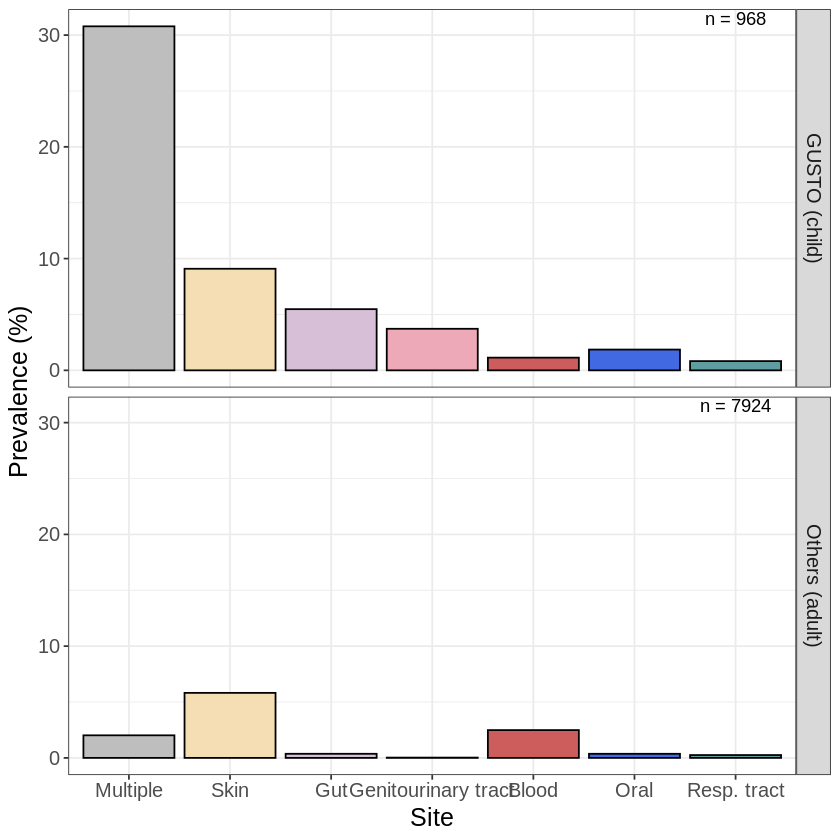

In [19]:
plot_df <- X_meta %>% 
    mutate(site_supplying_sample = ifelse(site_supplying_sample == "GUSTO", "GUSTO (child)", "Others (adult)")) %>%
    select(all_of(c(site_list, "site_supplying_sample"))) %>%
    pivot_longer(!site_supplying_sample, names_to = "site", values_to = "presence") %>%
    group_by(site_supplying_sample, site) %>%
    summarise(prev = sum(presence) / n(), n = n(), n_pos = sum(presence)) %>%
    filter(site_supplying_sample != "SSMP") %>%
    mutate(site = Hmisc::capitalize(site)) %>%
    mutate(site = ifelse(site == "Respiratory tract", "Resp. tract", site)) %>%
    arrange(desc(prev))

plot_df %>%
    mutate(site = factor(site, unique(plot_df$site))) %>%
    ggplot(aes(x = site, y = prev * 100, fill = site)) +
        facet_grid(rows = vars(site_supplying_sample)) +
        geom_bar(stat = "identity", color = "black") +
        theme_bw() +
        scale_fill_manual(values = pal) +
        geom_text(data = plot_df %>% distinct(n) %>% ungroup(),
                  aes(x = 7, y = Inf, 
                      label = paste0("n = ", n), 
                      group = site_supplying_sample),
                  inherit.aes = F,
                  vjust = 1.2) +
    labs(x = "Site", y = "Prevalence (%)") +
    theme(legend.position = "none",
          text = element_text(size = 15))

plot_df %>%
    fwrite("results/figure_source_data_nat_micro/child_adult_body_sites.csv")

ggsave("results/GUSTO_versus_rest/prevalence_site_by_cohort.pdf", dpi = 600, width = 12, height = 4)


### Genital microbes

In [10]:
interesting_list <- c("Fannyhessea vaginae", "Gardenerella vaginalis", 
                      "Lactobacillus crispatus", "Lactobacillus iners", 
                      "Lactobacillus jensenii")

`summarise()` has grouped output by 'site_supplying_sample', 'genetic_sex'. You can override using the `.groups` argument.
Joining with `by = join_by(taxa)`


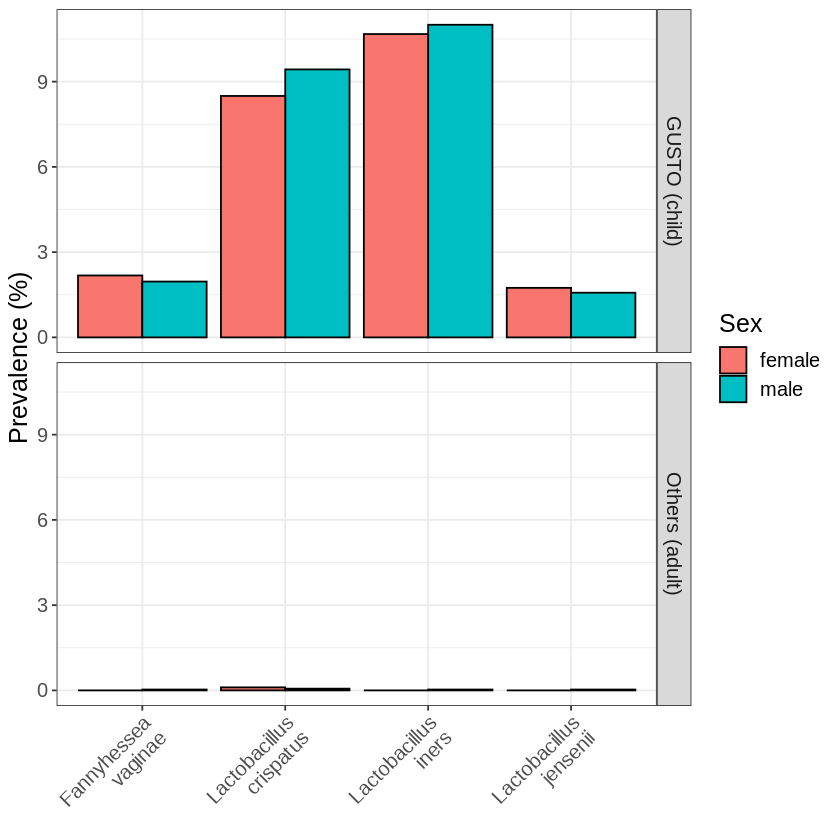

In [17]:
vag_df <- X %>%
    left_join(meta2 %>% select(npm_research_id, site_supplying_sample), "npm_research_id") %>%
    left_join(meta %>% select(npm_research_id, genetic_sex), "npm_research_id") %>%
    mutate(site_supplying_sample = ifelse(site_supplying_sample == "GUSTO", "GUSTO (child)", "Others (adult)")) %>%
    pivot_longer(!c(npm_research_id, site_supplying_sample, genetic_sex), 
                 names_to = "taxa", values_to = "presence") %>%
    filter(taxa %in% interesting_list) %>%
    group_by(site_supplying_sample, genetic_sex, taxa) %>%
    summarise(prev = sum(presence) / n(), n = n()) %>%
    left_join(commensals) %>%
    filter(!is.na(site)) %>%
    mutate(site = Hmisc::capitalize(site),
           taxa = gsub('\\s','\n', taxa)) %>%
    mutate(site = ifelse(site == "Respiratory tract", "Resp. tract", site)) %>%
    arrange(desc(prev), site)

vag_df %>%
    ggplot(aes(x = taxa, y = prev * 100, fill = genetic_sex)) +
    geom_bar(stat = "identity", color = "black", position = "dodge") +
    facet_grid(rows = vars(site_supplying_sample),
               scales = "free_x") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          axis.title.x = element_blank(),
          text = element_text(size = 15)) +
    labs(x = "Species", y = "Prevalence (%)", fill = "Sex")

vag_df %>%
    fwrite("results/figure_source_data_nat_micro/child_adult_genital_microbes.csv")

ggsave("results/GUSTO_versus_rest/genital_microbes_by_cohort_by_gender.pdf", dpi = 600, width = 5, height = 4)

### Gut microbes

`summarise()` has grouped output by 'site_supplying_sample', 'genetic_sex'. You can override using the `.groups` argument.
Joining with `by = join_by(taxa)`


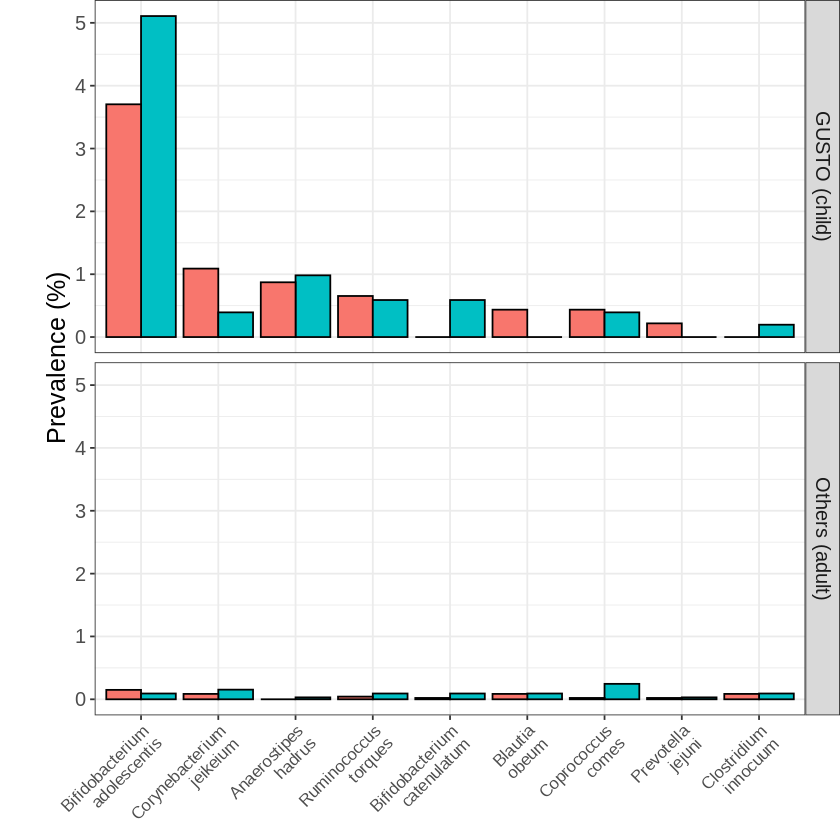

In [18]:
gut_df <- X %>%
    left_join(meta2 %>% select(npm_research_id, site_supplying_sample), "npm_research_id") %>%
    left_join(meta %>% select(npm_research_id, genetic_sex), "npm_research_id") %>%
    mutate(site_supplying_sample = ifelse(site_supplying_sample == "GUSTO", "GUSTO (child)", "Others (adult)")) %>%
    pivot_longer(!c(npm_research_id, site_supplying_sample, genetic_sex), 
                 names_to = "taxa", values_to = "presence") %>%
    group_by(site_supplying_sample, genetic_sex, taxa) %>%
    summarise(prev = sum(presence) / n(), n = n()) %>%
    left_join(commensals) %>%
    filter(!is.na(site)) %>%
    mutate(site = Hmisc::capitalize(site),
           taxa = gsub('\\s','\n', taxa)) %>%
    mutate(site = ifelse(site == "Respiratory tract", "Resp. tract", site)) %>%
    filter(site == "Gut") %>%
    arrange(desc(prev))

gut_df %>%
    mutate(taxa = factor(taxa, unique(gut_df$taxa))) %>%
    ggplot(aes(x = taxa, y = prev * 100, fill = genetic_sex)) +
    geom_bar(stat = "identity", color = "black", position = "dodge") +
    facet_grid(rows = vars(site_supplying_sample),
               scales = "free_x") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
          axis.title.x = element_blank(),
          text = element_text(size = 15),
          legend.position = "none",
          plot.margin = unit(c(0, 0, 0, 1), "cm")) +
    labs(x = "Species", y = "Prevalence (%)", fill = "Sex")

gut_df %>%
    fwrite("results/figure_source_data_nat_micro/child_adult_gut_microbes.csv")

ggsave("results/GUSTO_versus_rest/gut_microbes_by_cohort_by_gender.pdf", dpi = 600, width = 6, height = 4)

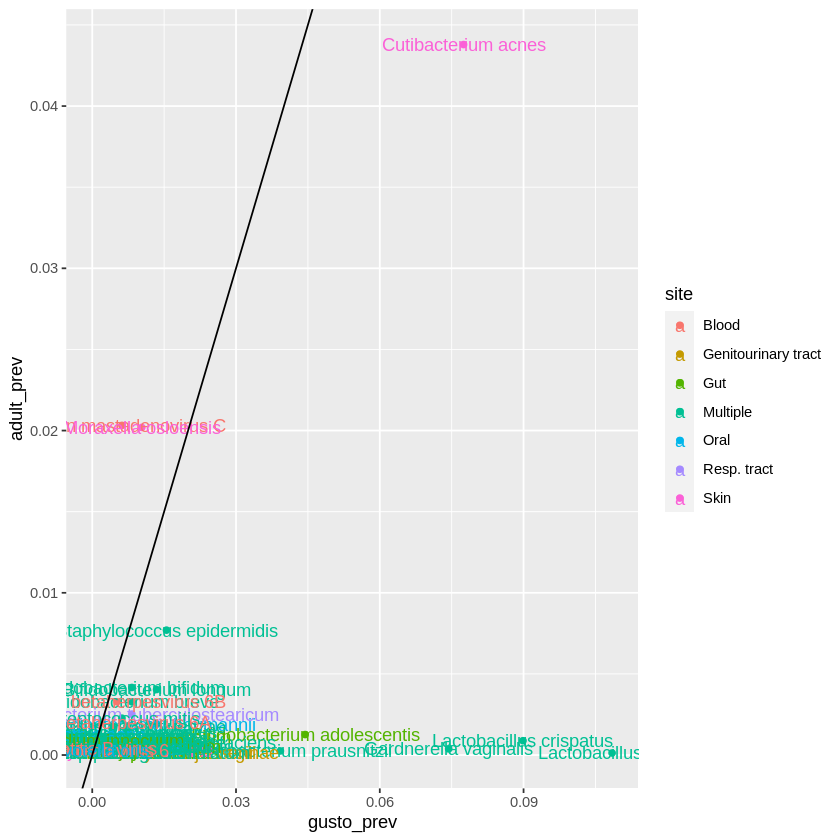

In [13]:
finer_plot_df %>%
    select(-n) %>%
    pivot_wider(id_cols = c(site, taxa), names_from = "site_supplying_sample", values_from = "prev") %>%
    rename(gusto_prev = "GUSTO (child)", adult_prev = "Others (adult)") %>%
    ggplot(aes(x = gusto_prev, y = adult_prev, color = site)) +
    geom_point() +
    geom_text(aes(label = taxa)) +
    geom_abline(slope = 1, intercept = 0)

In [14]:
fread("results/irep_analysis/coverage_irep_results.raw.csv") %>%
    filter(!is.na(bPTR)) %>%
    left_join(meta2 %>% select(npm_research_id, site_supplying_sample)) %>%
    select(prefix, site_supplying_sample)

Joining with `by = join_by(npm_research_id)`


prefix,site_supplying_sample
<chr>,<chr>
Acinetobacter_baumannii_NZ_CP043953.1,PRISM
Corynebacterium_segmentosum_NZ_LR134408.1,MEC
Cutibacterium_acnes_NC_021085.1,PRISM
Cutibacterium_acnes_NC_021085.1,MEC
Cutibacterium_acnes_NC_021085.1,MEC
Cutibacterium_acnes_NC_021085.1,MEC
Cutibacterium_acnes_NC_021085.1,MEC
Fannyhessea_vaginae_NZ_UFSV01000001.1,GUSTO
Fusobacterium_nucleatum_NZ_LN831027.1,GUSTO
